# Image-Based Structural Analysis
### Code created and maintained by Justin David Q. SAN JUAN, <br>email: jdqsj1997@yahoo.com, <br> personal website: justinsj.weebly.com

#### This code focuses in the segmentation and classification processes (except reconstruction) of the complete project pipeline as described below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/process-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

# Import Dependencies
#### Dependencies:
numpy: for handling data types (mostly handled as numpy arrays)<br>
Sequential (from keras.models): for CNN setup<br>
random: for pseudo-random shuffling of data<br>
cv2: for raw RBG image import and transformation to grayscale<br>
time: for measuring time elapsed per function<br>
##### Custom Classes:
ComponentSegmentation: for proposing regions of interest (RoI's)<br>
ExtractionPreprocessing: for trimming, noise removal, and resizing of image<br>
ComponentClassifierTraining: for loading the CNN model, training data, and training the model<br>
ComponentClassifierPredict: for using the CNN model to predict the class of preprocessed extractions<br>
ExtractionLabelling: for labelling ground truth bounding boxes and classes in problem images<br>
TestingClass: for testing the accuracy of a CNN model on the problem images<br>
<br>
print_image_bw is used to print a simple 2-D array<br>
gc: for clearing up space after acquiring data from larger datasets

In [1]:
from __future__ import print_function
import numpy as np

from keras.models import Sequential

import random

import cv2
import time

from component_segmentation import ComponentSegmentation
from extraction_preprocessing import ExtractionPreprocessing
from component_classifier_training import ComponentClassifierTraining
from component_classifier_predict import ComponentClassifierPredict
from extraction_labelling import ExtractionLabelling
from testing_class import TestingClass
from helper_functions import print_image_bw
from helper_functions import plot_model_results_and_save
from helper_functions import print_time_string, store_time

import gc
gc.enable()

print('Done Importing...')

Using TensorFlow backend.


Done Importing...


# Hyper-parameters
#### Selective Search Parameters:
scale_input<br>
sigma_input<br>
min_size_input<br>
#### Noise Reduction Parameters:
min_shape: for minimum number of black pixels in bounding box<br>
min_height: for minimum height of bounding box<br>
min_width: for minimum width of bounding box<br>
<br>
buffer_zone: for expanding bounding box all directions<br>
min_area: for minimum area of bounding box<br>
min_black: for minimum number of black pixels in bounding box<br>
min_black_ratio: for minimum ratio of black pixels to the bounding box area<br>
#### Overlap Parameters:
overlap_repeats: for number of iterations for merging algorithm to be applied<br>
overlap_threshold: threshold of area overlap over union area for merging to be applied<br>
#### Removing Unconnected Pieces Parameters:
max_piece_percent: maximum percentage of piece to be removed<br>
(if percentage is larger, piece will not be removed as it is more likely an important piece)<br>
#### Extractions Preprocessing Parameters:
img_rows, img_cols: for classifier input shape<br>
wanted_w, wanted_h: for black pixels edges resizing boundary shape<br>
export_w, export_h: for overall image resizing shape ([export_w-wanted_w]/2 = horizontal buffer on each side)<br>
#### CNN Training Parameters:
num_classes: number of classes for classifier to predict<br>
TRAINING_RATIO_TRAIN: ratio of training samples to total number of samples<br>
TRAINING_RATIO_VAL: ratio of validation samples to total number of samples<br>
TRAINING_RATIO_TEST: ratio of test samples to total number of samples <br>
Note: TRAINING_RATIO_TEST is implicitly calculated as [1-{TRAINING_RATIO_TRAIN + TRAINING_RATIO_VAL}]<br>
dropout: dropout value to be used in all layers except last layer of Sketch-A-Net CNN model<br>
#### CNN Prediction Parameters:
min_percent_match: minimum probability of class prediction for that class to be set as the prediction<br>
min_confidence: minimum difference between first-highest % match and second-highest % match<br>
(higher difference means less ambiguity between first and second highest match, which means less likelihood of random object)<br>
##### The directory is also defined in the PATH variable.<br>The name of the CNN model data is defined in the name variable.<br>The training data set name for the CNN is defined in the data_set_name variable.

In [2]:
#selective search parameters
scale_input=200 #200 previous: #10
sigma_input=10 #10 previous: #15
min_size_input=10 #10 previous: #5

#noise reduction parameters
min_shape=10 #min. number of black pixels  
min_height=3 #min. height of bounding box
min_width=3 #min. width of bounding box

buffer_zone=2 #expand bounding box by this amount in all directions  
min_area=100 #min. area of bounding box
min_black=10 #min. number of black pixels
min_black_ratio=0.01 #min ratio of black pixels to the bounding box area

#Overlap parameters
overlap_repeats = 4 #set to 8
overlap_threshold = 0.3 #set to 0.3 (overlap has to be larger than the threshold)

#Removing unconnected pieces parameters
max_piece_percent=0.3  # set to 0.3

#Extractions preprocessing paramaters
img_rows, img_cols = 100,100
wanted_w, wanted_h, export_w, export_h = img_cols, img_rows, img_cols, img_rows

#CNN training parameters
num_classes = 64
TRAINING_RATIO_TRAIN = 0.7
TRAINING_RATIO_VAL = 0.15
dropout = 0

#CNN prediction parameters
min_percent_match = 0 # set to 0.7
min_confidence = 0 # set to 0.3

#Time Cost parameters
time_cost_string_list = ['Loading image','Component Segmentation','Extraction Preprocessing',
                         'Component Classifier Training','Component Classifier Predict',
                        'Printing Results','Acquiring and Printing Ground Truth Data',
                        'Data Concatenation & Cleaning','Data Control, Counting, & Training from Multiple Files',
                        'Testing','Printing Confusion Matrix']
time_cost_time_list = np.zeros(len(time_cost_string_list)).astype(np.int).tolist()

#Paths and names
PATH = 'C:/Users/JustinSanJuan/Desktop/Workspace/python/Testing Folder/' #must have "/" at the end

name = 'Sketch-a-Net_64_classes_100x100_0.0_all_100epochs'

base_dataset_name = 'Training_Samples_64_classes_100x100_all'

dataset_PATH = 'C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/'
dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'
new_dataset_name = 'Training_Samples_64_classes_100x100_all_cleaned_32898'

print('Done setting hyperparamters...')

Done setting hyperparamters...


# Load Image
Image (binary, grayscale, 2D, numpy array) for regions of interest proposals is loaded.

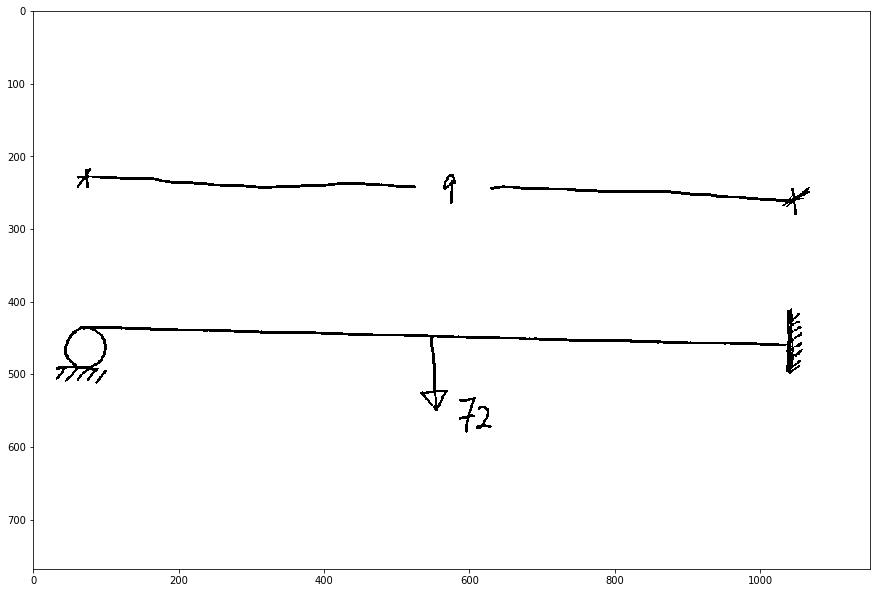

Loading image done... Time Elapsed : 0.8758745193481445 seconds...


In [3]:
start = time.time() # Begin time measurement

image_index = 50
image_set = np.load(PATH+'easy_training_images.npy')
image = np.copy(image_set[:,:,image_index])
image_set = None #clear image_set
gc.collect() #clear unreferenced data

l,w = 15,15 #dimension scales of print
print_image_bw(image,l,w)
      
end = time.time()#record time
time_cost_time_list = store_time(0,time_cost_time_list,end-start)
print_time_string(0,time_cost_string_list,time_cost_time_list)

# Component Segmentation
##### Using the ComponentSegmentation class:
    1. Selective Search is applied to the image (to generate bounding boxes)
    2. A merging algorithm is applied to the selective search bounding boxes (to merge highly overlapping bounding boxes)
##### The ComponentSegmentation uses the following data for initialization:
    - image: binary (grayscale) 2-D array for region proposal
    - name: for unique prints saving
    - min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio: for noise reduction
    - overlap_repeats, overlap_threshold: for merging algorithm
##### Then, the RoI proposal is done using the custom search method, which uses the selective search hyper-parameters:
    - scale_input
    - sigma_input
    - min_size_input
##### Then, the merging algorithm is applied within the search function, and a merged_set is retrieved.

Premerged Set


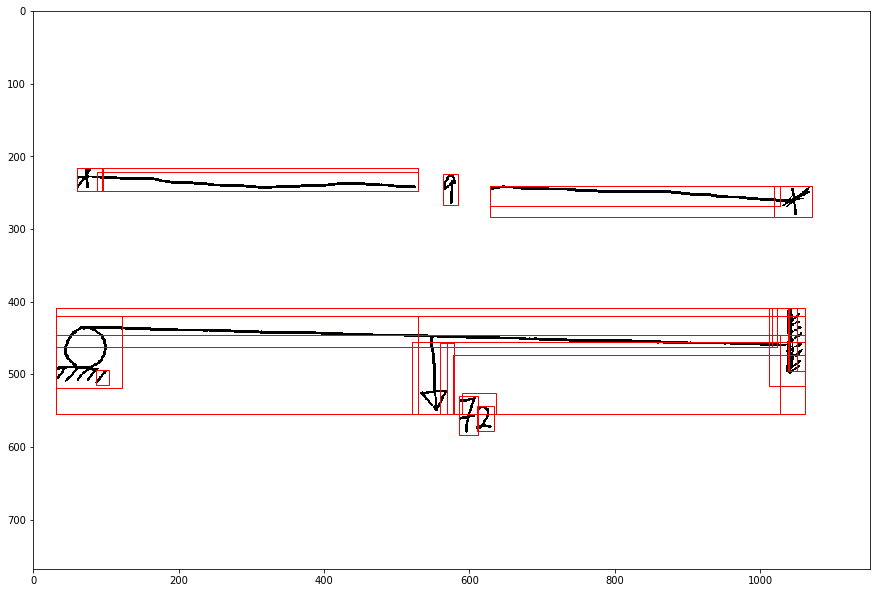

Merged Set


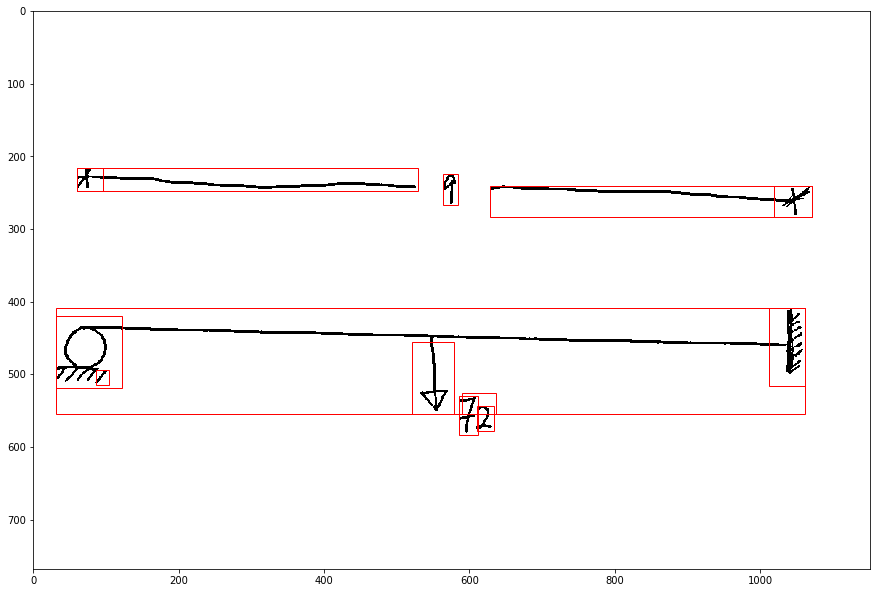

Component Segmentation done... Time Elapsed : 1.8053901195526123 seconds...


In [4]:
start = time.time() # Begin time measurement

#Create object ComponentSegmentation, which will use the search function to perform segmentation and merging.
segmentation_obj = ComponentSegmentation(image, name, min_shape, min_height, min_width, buffer_zone, min_area, min_black, min_black_ratio, overlap_repeats, overlap_threshold)
segmentation_obj.search(scale_input, sigma_input, min_size_input) # run search (segmentation code)
merged_set = segmentation_obj.merged_set

end = time.time()#record time
time_cost_time_list = store_time(1,time_cost_time_list,end-start)
print_time_string(1,time_cost_string_list,time_cost_time_list)

# ExtractionPreprocessing
#### Merged set from ComponentSegmentation is passed to ExtractionPreprocessing and the following is applied:
    1. Trim: extra space around the farthest black pixels are removed
    2. Remove Unconnected Parts: extra pixels (from other components) captured by the bounding box are removed
    3. Trim: trimming again as empty spaces may be released
    4. Resize: extraction is resized to the prescribed 100x100 dimension using max pooling for downsampling to preserve data
ext_images_list = extraction images: list of 100x100 binary (grayscale) 2-D arrays<br>
ext_data_list = extraction data: list of x, y, w, h data of extractions bounding boxes<br> 
where:<br>
    - x, y: top-left corner coordinates of bounding box
    - w, h: width and height of bounding box respectively
#### The preprocess_extractions function is called and the extraction images and extraction data are acquired.
#### The plot_bounding_boxes_with_names function is then used to display the bounding boxes on the original image.

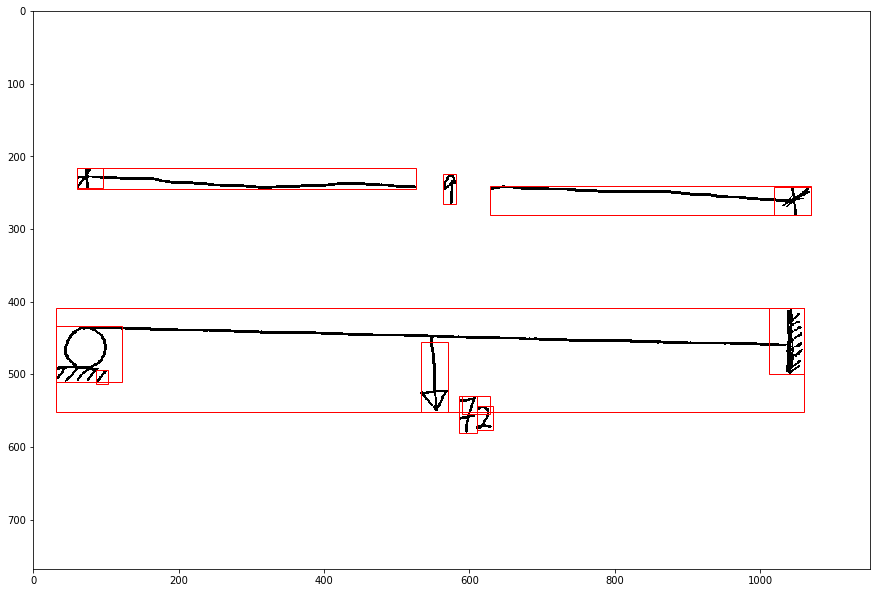

Extraction Preprocessing done... Time Elapsed : 2.502673387527466 seconds...


In [5]:
start = time.time() # Begin time measurement

#Transport data into ExtractionPreprocessing class, which will trim, remove unconnected parts, then trim, and resize
extraction_obj = ExtractionPreprocessing(image, name, merged_set)

# Get 4 lists from preprocess_extractions function
ext_images_list, ext_data_list = extraction_obj.preprocess_extractions(wanted_w, wanted_h, export_w, export_h, max_piece_percent)
extraction_obj.plot_bounding_boxes_with_names()

end = time.time()#record time
time_cost_time_list = store_time(2,time_cost_time_list,end-start)
print_time_string(2,time_cost_string_list,time_cost_time_list)

# ComponentClassifierTraining (Not pre-trained)
### If model has been trained before:
### Then the train and save functions should be replaced with:
training_obj.model.load_weights(PATH+name+'.h5')
### Such that the below code is the following:
training_obj = ComponentClassifierTraining(PATH, data_set_name, num_classes, dropout, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)<br>
training_obj.shuffle_data(training_obj.load_data(PATH,data_set_name),1000)<br>
<br>
#Model is Sketch_a_net<br>
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])<br>
training_obj.model.load_weights(PATH+name+'.h5')<br>
##### The ComponentClassifierTraining object is first initialized with:
    - PATH: working directory
    - data_set_name: for loading training data set
    - num_classes, dropout: CNN model parameters
    - TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL: training parameters
##### The shuffle_data is then called to shuffle the training data using a seed<br>The Sketch_A_Net model is then loaded<br>Then the model is trained with 100 epochs<br>Then the model weights are saved<br>Finally the trained model is stored in trained_model to be passed onto a ComponentClassifierPredict object
#### If model weights have been trained before, the training and saving is not required, and the load_weights function has to be called instead.

In [6]:
start = time.time() # Begin time measurement

seed = 1000
i = 1234
training_obj = ComponentClassifierTraining(num_classes,TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
training_obj.shuffle_data(training_obj.load_data(dataset_PATH,dataset_name),seed)

#Model is Sketch_a_net
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes, training_obj.X_train.shape[1:])

#training_obj.train(100,seed)
#training_obj.save(name+'_'+str(i))
training_obj.model.load_weights(dataset_PATH+name+'.h5')

trained_model = training_obj.model

end = time.time()#record time
time_cost_time_list = store_time(3,time_cost_time_list,end-start)
print_time_string(3,time_cost_string_list,time_cost_time_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 29, 64)        14464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 256)       295168    
__________

# ComponentClassifierPredict
### The ComponentClassifierPredict object is first initialized with the entropy-based hyperparameters:
    - min_percent_match
    - min_confidence
These parameters were explained in the Hyperparameters section above.
### The predict_classes function produces the following:
    - ext_class_index_list: ordered list of highest % match class predictions for each
The entropy-based modifications are applied to the above (such that if any of the two criteria are not satisfied, the prediction is classified as random)
    - ext_class_name_list: ordered list of corresponding names to ext_class_index_list
    - ext_match_first_max_percent_list: ordered list of corresponding first-highest match percentage
    - ext_match_second_max_percent_list: ordered list of corresponding second-highest match percentage

In [7]:
start = time.time() # Begin time measurement

prediction_obj = ComponentClassifierPredict(min_percent_match, min_confidence)

ext_class_index_list, ext_class_name_list, \
ext_match_first_max_percent_list, \
ext_match_second_max_percent_list = prediction_obj.predict_classes(ext_images_list,trained_model)

end = time.time()#record time
time_cost_time_list = store_time(4,time_cost_time_list,end-start)
print_time_string(4,time_cost_string_list,time_cost_time_list)

Component Classifier Predict done... Time Elapsed : 0.26722288131713867 seconds...


# Printing Results
#### Results are plotted on the original image using:
    - image: for background
    - name: for saving
    - ext_data_list: list of x, y, w, h coordinates for each bounding box
    - ext_class_index_list: list of predicted class indices
    - ext_class_name_list: list of corresponding class names per predicted index
    - ground_truth_index_list: list of ground truth class indices (currently set as the predicted classes.)*
##### Each bounding box is labelled with two items separated by a colon:
    - First: index of that object in the full list.
    - Second: predicted class name of that object.
##### If the predicted class matches with the ground truth class, <br> then the predicted label is coloured green, otherwise it is red. <br> * For this example, the ground truth labels were set as the predicted classes, so all labels are green.

C:\Users\JustinSanJuan\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:571: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\JustinSanJuan\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:574: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\JustinSanJuan\Desktop\Workspace\python\isa_python\adjustText.py:31: RuntimeWarning: invalid value encountered in greater
  y_in = np.logical_and(y>y1, y<y2)
C:\Users\JustinSanJuan\Desktop\Workspace\python\isa_python\adjustText.py:31: RuntimeWarning: invalid value encountered in less
  y_in = np.logical_and(y>y1, y<y2)


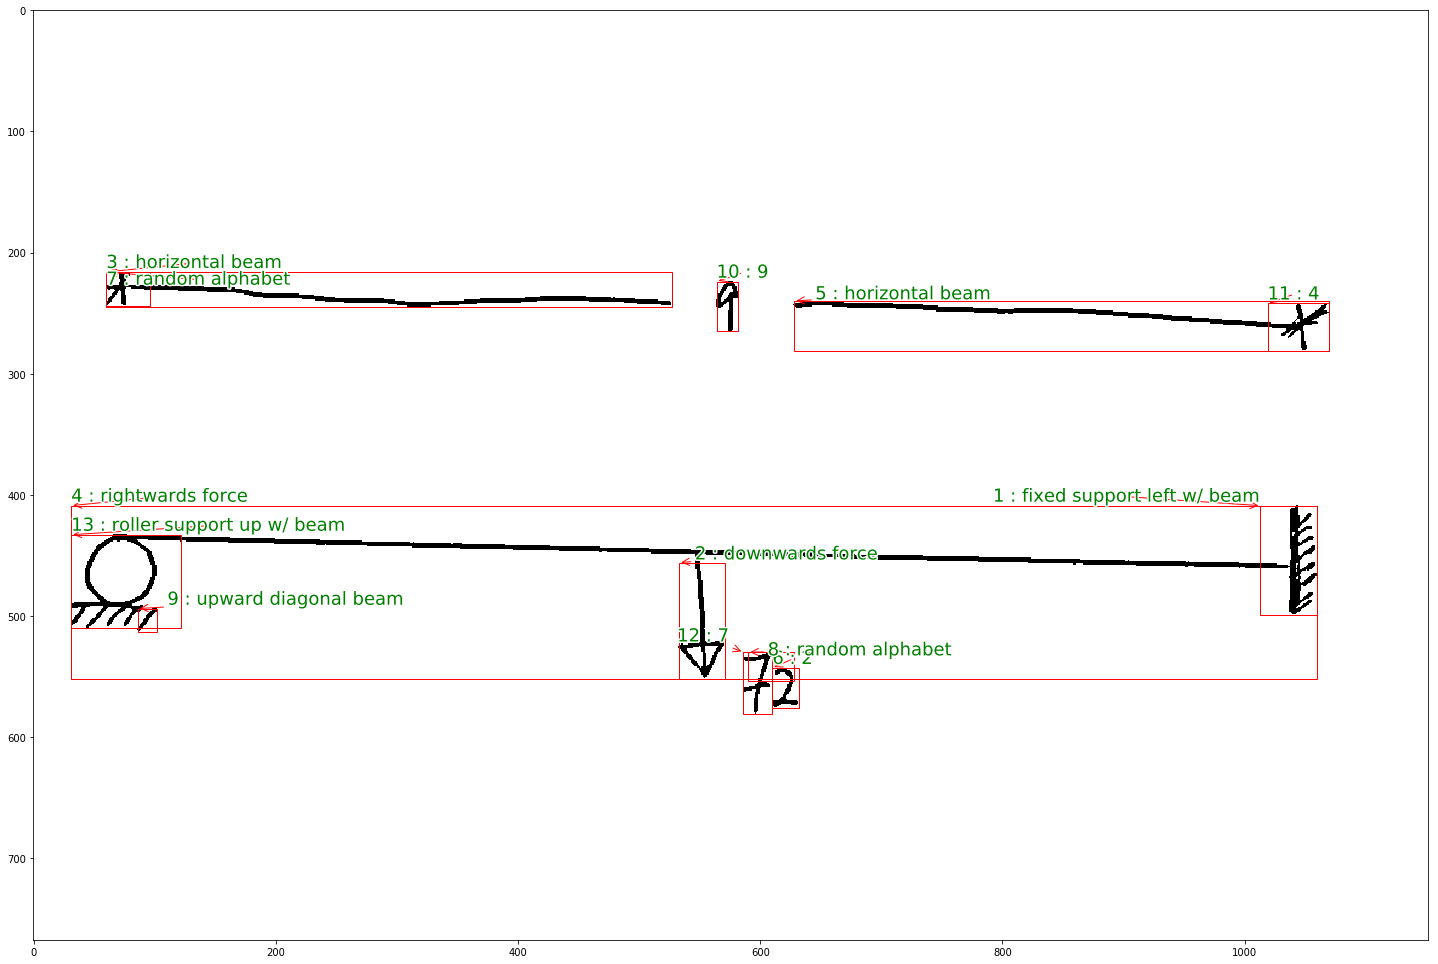

Printing Results done... Time Elapsed : 2.0663440227508545 seconds...


In [8]:
start = time.time() # Begin time measurement

ground_truth_index_list = ext_class_index_list # set all answers as correct answers for now
plot_model_results_and_save(image,name, ext_data_list, ext_class_index_list, ext_class_name_list, ground_truth_index_list)

end = time.time()#record time
time_cost_time_list = store_time(5,time_cost_time_list,end-start)
print_time_string(5,time_cost_string_list,time_cost_time_list)

# ExtractionLabelling
#### The ExtractionLabelling class is used to label the problem image with ground truths in the form of x, y, w, h, c <br>where x, y, w, h are the coordinates of the bounding box, and c is the class of the object in the box.
#### The class is an interactive program where the user will be asked to verify the correctness <br> of the bounding box regions and classes predicted by the current best segmentation + classification algorithm.
##### The class is initialized using:
    - PATH: working directory
    - ext_images_list: list of extraction images
    - ext_data_list: list of extraction image coordinates (x, y, w, h)
    - ext_class_index_list: list of predicted class indices (c)
    - ext_class_name_list: list of predicted class names
    - num_classes, img_rows, img_cols: selected CNN model parameters
##### The define_model function is then called to load the model (from the trained_model variable). <br> Then the select_good_bounding_boxes function is called to allow the user to verify the bounding boxes and predicted classes. <br> Finally, after all the objects have been segmented and classified and saved in a text file, the data is plotted on the original image.
##### The process of the interactive program is described in the diagram below:
<img src="https://justinsj.weebly.com/uploads/6/4/9/2/64923303/extraction-labelling-flowchart_orig.jpg" alt="Drawing" style="width: 800px;"/>

printing ground truths for review...


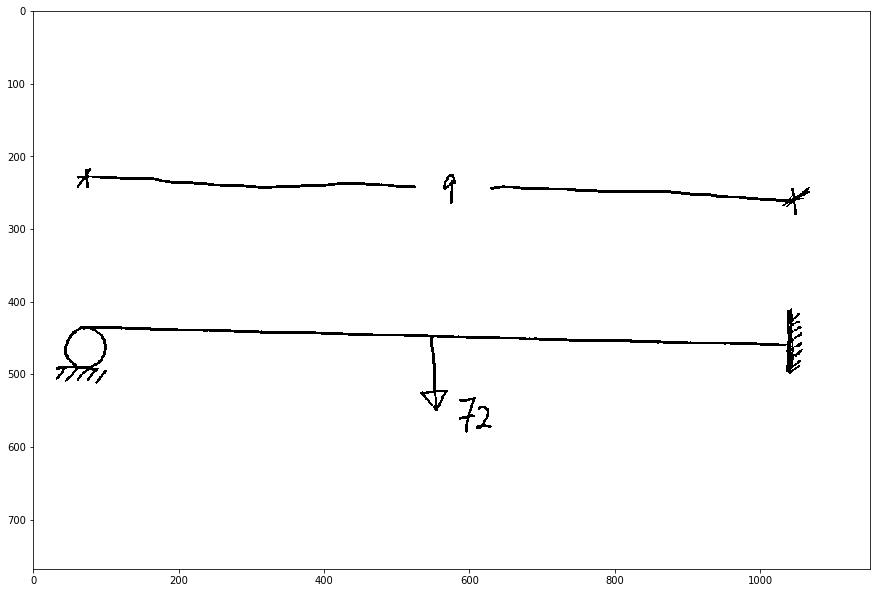

Acquiring and Printing Ground Truth Data done... Time Elapsed : 0.3609609603881836 seconds...


In [ ]:
start = time.time() # Begin time measurement

labelling_obj = ExtractionLabelling(ext_images_list, ext_data_list,ext_class_index_list, ext_class_name_list, 
                          num_classes, img_rows, img_cols)

labelling_obj.define_model(trained_model)
#labelling_obj.select_good_bounding_boxes(image, dataset_PATH,"easy_" + str(image_index))
labelling_obj.plot_ground_truths(image, dataset_PATH,"easy_" + str(image_index))

end = time.time()#record time
time_cost_time_list = store_time(6,time_cost_time_list,end-start)
print_time_string(6,time_cost_string_list,time_cost_time_list)

# Active Learning<br>Data Concatenation & Cleaning
#### A dataset by name is added into the training dataset for improvement in accuracy

In [ ]:
start = time.time() # Begin time measurement

dataset_name_1 = "Training_Samples_64_classes_100x100_all_cleaned_29724" # base training images
dataset_name_2 = "Training_Samples_64_classes_100x100_all_cleaned_13291" # problem ground truth images
dataset_name_list = [dataset_name_1, dataset_name_2]

cleaned_datasets_list = labelling_obj.clean_datasets(dataset_PATH,dataset_name_list)
final_dataset_name = labelling_obj.concatenate_datasets(dataset_PATH, dataset_name_list, start, end) #**kwargs: suffix, exclude

end = time.time()#record time
time_cost_time_list = store_time(7,time_cost_time_list,end-start)
print_time_string(7,time_cost_string_list,time_cost_time_list)

saved as :C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/Training_Samples_64_classes_100x100_all_cleaned_29724
saved as :C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/Training_Samples_64_classes_100x100_all_cleaned_13291
Updating answers...
Adding 0 training samples to training set...
Inital length = 29724
0 / 29724 of data_all
1 / 29724 of data_all
2 / 29724 of data_all
3 / 29724 of data_all
4 / 29724 of data_all
5 / 29724 of data_all
6 / 29724 of data_all
7 / 29724 of data_all
8 / 29724 of data_all
9 / 29724 of data_all
10 / 29724 of data_all
11 / 29724 of data_all
12 / 29724 of data_all
13 / 29724 of data_all
14 / 29724 of data_all
15 / 29724 of data_all
16 / 29724 of data_all
17 / 29724 of data_all
18 / 29724 of data_all
19 / 29724 of data_all
20 / 29724 of data_all
21 / 29724 of data_all
22 / 29724 of data_all
23 / 29724 of data_all
24 / 29724 of

411 / 29724 of data_all
412 / 29724 of data_all
413 / 29724 of data_all
414 / 29724 of data_all
415 / 29724 of data_all
416 / 29724 of data_all
417 / 29724 of data_all
418 / 29724 of data_all
419 / 29724 of data_all
420 / 29724 of data_all
421 / 29724 of data_all
422 / 29724 of data_all
423 / 29724 of data_all
424 / 29724 of data_all
425 / 29724 of data_all
426 / 29724 of data_all
427 / 29724 of data_all
428 / 29724 of data_all
429 / 29724 of data_all
430 / 29724 of data_all
431 / 29724 of data_all
432 / 29724 of data_all
433 / 29724 of data_all
434 / 29724 of data_all
435 / 29724 of data_all
436 / 29724 of data_all
437 / 29724 of data_all
438 / 29724 of data_all
439 / 29724 of data_all
440 / 29724 of data_all
441 / 29724 of data_all
442 / 29724 of data_all
443 / 29724 of data_all
444 / 29724 of data_all
445 / 29724 of data_all
446 / 29724 of data_all
447 / 29724 of data_all
448 / 29724 of data_all
449 / 29724 of data_all
450 / 29724 of data_all
451 / 29724 of data_all
452 / 29724 of d

987 / 29724 of data_all
988 / 29724 of data_all
989 / 29724 of data_all
990 / 29724 of data_all
991 / 29724 of data_all
992 / 29724 of data_all
993 / 29724 of data_all
994 / 29724 of data_all
995 / 29724 of data_all
996 / 29724 of data_all
997 / 29724 of data_all
998 / 29724 of data_all
999 / 29724 of data_all
1000 / 29724 of data_all
1001 / 29724 of data_all
1002 / 29724 of data_all
1003 / 29724 of data_all
1004 / 29724 of data_all
1005 / 29724 of data_all
1006 / 29724 of data_all
1007 / 29724 of data_all
1008 / 29724 of data_all
1009 / 29724 of data_all
1010 / 29724 of data_all
1011 / 29724 of data_all
1012 / 29724 of data_all
1013 / 29724 of data_all
1014 / 29724 of data_all
1015 / 29724 of data_all
1016 / 29724 of data_all
1017 / 29724 of data_all
1018 / 29724 of data_all
1019 / 29724 of data_all
1020 / 29724 of data_all
1021 / 29724 of data_all
1022 / 29724 of data_all
1023 / 29724 of data_all
1024 / 29724 of data_all
1025 / 29724 of data_all
1026 / 29724 of data_all
1027 / 29724 

1864 / 29724 of data_all
1865 / 29724 of data_all
1866 / 29724 of data_all
1867 / 29724 of data_all
1868 / 29724 of data_all
1869 / 29724 of data_all
1870 / 29724 of data_all
1871 / 29724 of data_all
1872 / 29724 of data_all
1873 / 29724 of data_all
1874 / 29724 of data_all
1875 / 29724 of data_all
1876 / 29724 of data_all
1877 / 29724 of data_all
1878 / 29724 of data_all
1879 / 29724 of data_all
1880 / 29724 of data_all
1881 / 29724 of data_all
1882 / 29724 of data_all
1883 / 29724 of data_all
1884 / 29724 of data_all
1885 / 29724 of data_all
1886 / 29724 of data_all
1887 / 29724 of data_all
1888 / 29724 of data_all
1889 / 29724 of data_all
1890 / 29724 of data_all
1891 / 29724 of data_all
1892 / 29724 of data_all
1893 / 29724 of data_all
1894 / 29724 of data_all
1895 / 29724 of data_all
1896 / 29724 of data_all
1897 / 29724 of data_all
1898 / 29724 of data_all
1899 / 29724 of data_all
1900 / 29724 of data_all
1901 / 29724 of data_all
1902 / 29724 of data_all
1903 / 29724 of data_all


2408 / 29724 of data_all
2409 / 29724 of data_all
2410 / 29724 of data_all
2411 / 29724 of data_all
2412 / 29724 of data_all
2413 / 29724 of data_all
2414 / 29724 of data_all
2415 / 29724 of data_all
2416 / 29724 of data_all
2417 / 29724 of data_all
2418 / 29724 of data_all
2419 / 29724 of data_all
2420 / 29724 of data_all
2421 / 29724 of data_all
2422 / 29724 of data_all
2423 / 29724 of data_all
2424 / 29724 of data_all
2425 / 29724 of data_all
2426 / 29724 of data_all
2427 / 29724 of data_all
2428 / 29724 of data_all
2429 / 29724 of data_all
2430 / 29724 of data_all
2431 / 29724 of data_all
2432 / 29724 of data_all
2433 / 29724 of data_all
2434 / 29724 of data_all
2435 / 29724 of data_all
2436 / 29724 of data_all
2437 / 29724 of data_all
2438 / 29724 of data_all
2439 / 29724 of data_all
2440 / 29724 of data_all
2441 / 29724 of data_all
2442 / 29724 of data_all
2443 / 29724 of data_all
2444 / 29724 of data_all
2445 / 29724 of data_all
2446 / 29724 of data_all
2447 / 29724 of data_all


2968 / 29724 of data_all
2969 / 29724 of data_all
2970 / 29724 of data_all
2971 / 29724 of data_all
2972 / 29724 of data_all
2973 / 29724 of data_all
2974 / 29724 of data_all
2975 / 29724 of data_all
2976 / 29724 of data_all
2977 / 29724 of data_all
2978 / 29724 of data_all
2979 / 29724 of data_all
2980 / 29724 of data_all
2981 / 29724 of data_all
2982 / 29724 of data_all
2983 / 29724 of data_all
2984 / 29724 of data_all
2985 / 29724 of data_all
2986 / 29724 of data_all
2987 / 29724 of data_all
2988 / 29724 of data_all
2989 / 29724 of data_all
2990 / 29724 of data_all
2991 / 29724 of data_all
2992 / 29724 of data_all
2993 / 29724 of data_all
2994 / 29724 of data_all
2995 / 29724 of data_all
2996 / 29724 of data_all
2997 / 29724 of data_all
2998 / 29724 of data_all
2999 / 29724 of data_all
3000 / 29724 of data_all
3001 / 29724 of data_all
3002 / 29724 of data_all
3003 / 29724 of data_all
3004 / 29724 of data_all
3005 / 29724 of data_all
3006 / 29724 of data_all
3007 / 29724 of data_all


3533 / 29724 of data_all
3534 / 29724 of data_all
3535 / 29724 of data_all
3536 / 29724 of data_all
3537 / 29724 of data_all
3538 / 29724 of data_all
3539 / 29724 of data_all
3540 / 29724 of data_all
3541 / 29724 of data_all
3542 / 29724 of data_all
3543 / 29724 of data_all
3544 / 29724 of data_all
3545 / 29724 of data_all
3546 / 29724 of data_all
3547 / 29724 of data_all
3548 / 29724 of data_all
3549 / 29724 of data_all
3550 / 29724 of data_all
3551 / 29724 of data_all
3552 / 29724 of data_all
3553 / 29724 of data_all
3554 / 29724 of data_all
3555 / 29724 of data_all
3556 / 29724 of data_all
3557 / 29724 of data_all
3558 / 29724 of data_all
3559 / 29724 of data_all
3560 / 29724 of data_all
3561 / 29724 of data_all
3562 / 29724 of data_all
3563 / 29724 of data_all
3564 / 29724 of data_all
3565 / 29724 of data_all
3566 / 29724 of data_all
3567 / 29724 of data_all
3568 / 29724 of data_all
3569 / 29724 of data_all
3570 / 29724 of data_all
3571 / 29724 of data_all
3572 / 29724 of data_all


4073 / 29724 of data_all
4074 / 29724 of data_all
4075 / 29724 of data_all
4076 / 29724 of data_all
4077 / 29724 of data_all
4078 / 29724 of data_all
4079 / 29724 of data_all
4080 / 29724 of data_all
4081 / 29724 of data_all
4082 / 29724 of data_all
4083 / 29724 of data_all
4084 / 29724 of data_all
4085 / 29724 of data_all
4086 / 29724 of data_all
4087 / 29724 of data_all
4088 / 29724 of data_all
4089 / 29724 of data_all
4090 / 29724 of data_all
4091 / 29724 of data_all
4092 / 29724 of data_all
4093 / 29724 of data_all
4094 / 29724 of data_all
4095 / 29724 of data_all
4096 / 29724 of data_all
4097 / 29724 of data_all
4098 / 29724 of data_all
4099 / 29724 of data_all
4100 / 29724 of data_all
4101 / 29724 of data_all
4102 / 29724 of data_all
4103 / 29724 of data_all
4104 / 29724 of data_all
4105 / 29724 of data_all
4106 / 29724 of data_all
4107 / 29724 of data_all
4108 / 29724 of data_all
4109 / 29724 of data_all
4110 / 29724 of data_all
4111 / 29724 of data_all
4112 / 29724 of data_all


4635 / 29724 of data_all
4636 / 29724 of data_all
4637 / 29724 of data_all
4638 / 29724 of data_all
4639 / 29724 of data_all
4640 / 29724 of data_all
4641 / 29724 of data_all
4642 / 29724 of data_all
4643 / 29724 of data_all
4644 / 29724 of data_all
4645 / 29724 of data_all
4646 / 29724 of data_all
4647 / 29724 of data_all
4648 / 29724 of data_all
4649 / 29724 of data_all
4650 / 29724 of data_all
4651 / 29724 of data_all
4652 / 29724 of data_all
4653 / 29724 of data_all
4654 / 29724 of data_all
4655 / 29724 of data_all
4656 / 29724 of data_all
4657 / 29724 of data_all
4658 / 29724 of data_all
4659 / 29724 of data_all
4660 / 29724 of data_all
4661 / 29724 of data_all
4662 / 29724 of data_all
4663 / 29724 of data_all
4664 / 29724 of data_all
4665 / 29724 of data_all
4666 / 29724 of data_all
4667 / 29724 of data_all
4668 / 29724 of data_all
4669 / 29724 of data_all
4670 / 29724 of data_all
4671 / 29724 of data_all
4672 / 29724 of data_all
4673 / 29724 of data_all
4674 / 29724 of data_all


5203 / 29724 of data_all
5204 / 29724 of data_all
5205 / 29724 of data_all
5206 / 29724 of data_all
5207 / 29724 of data_all
5208 / 29724 of data_all
5209 / 29724 of data_all
5210 / 29724 of data_all
5211 / 29724 of data_all
5212 / 29724 of data_all
5213 / 29724 of data_all
5214 / 29724 of data_all
5215 / 29724 of data_all
5216 / 29724 of data_all
5217 / 29724 of data_all
5218 / 29724 of data_all
5219 / 29724 of data_all
5220 / 29724 of data_all
5221 / 29724 of data_all
5222 / 29724 of data_all
5223 / 29724 of data_all
5224 / 29724 of data_all
5225 / 29724 of data_all
5226 / 29724 of data_all
5227 / 29724 of data_all
5228 / 29724 of data_all
5229 / 29724 of data_all
5230 / 29724 of data_all
5231 / 29724 of data_all
5232 / 29724 of data_all
5233 / 29724 of data_all
5234 / 29724 of data_all
5235 / 29724 of data_all
5236 / 29724 of data_all
5237 / 29724 of data_all
5238 / 29724 of data_all
5239 / 29724 of data_all
5240 / 29724 of data_all
5241 / 29724 of data_all
5242 / 29724 of data_all


5738 / 29724 of data_all
5739 / 29724 of data_all
5740 / 29724 of data_all
5741 / 29724 of data_all
5742 / 29724 of data_all
5743 / 29724 of data_all
5744 / 29724 of data_all
5745 / 29724 of data_all
5746 / 29724 of data_all
5747 / 29724 of data_all
5748 / 29724 of data_all
5749 / 29724 of data_all
5750 / 29724 of data_all
5751 / 29724 of data_all
5752 / 29724 of data_all
5753 / 29724 of data_all
5754 / 29724 of data_all
5755 / 29724 of data_all
5756 / 29724 of data_all
5757 / 29724 of data_all
5758 / 29724 of data_all
5759 / 29724 of data_all
5760 / 29724 of data_all
5761 / 29724 of data_all
5762 / 29724 of data_all
5763 / 29724 of data_all
5764 / 29724 of data_all
5765 / 29724 of data_all
5766 / 29724 of data_all
5767 / 29724 of data_all
5768 / 29724 of data_all
5769 / 29724 of data_all
5770 / 29724 of data_all
5771 / 29724 of data_all
5772 / 29724 of data_all
5773 / 29724 of data_all
5774 / 29724 of data_all
5775 / 29724 of data_all
5776 / 29724 of data_all
5777 / 29724 of data_all


6299 / 29724 of data_all
6300 / 29724 of data_all
6301 / 29724 of data_all
6302 / 29724 of data_all
6303 / 29724 of data_all
6304 / 29724 of data_all
6305 / 29724 of data_all
6306 / 29724 of data_all
6307 / 29724 of data_all
6308 / 29724 of data_all
6309 / 29724 of data_all
6310 / 29724 of data_all
6311 / 29724 of data_all
6312 / 29724 of data_all
6313 / 29724 of data_all
6314 / 29724 of data_all
6315 / 29724 of data_all
6316 / 29724 of data_all
6317 / 29724 of data_all
6318 / 29724 of data_all
6319 / 29724 of data_all
6320 / 29724 of data_all
6321 / 29724 of data_all
6322 / 29724 of data_all
6323 / 29724 of data_all
6324 / 29724 of data_all
6325 / 29724 of data_all
6326 / 29724 of data_all
6327 / 29724 of data_all
6328 / 29724 of data_all
6329 / 29724 of data_all
6330 / 29724 of data_all
6331 / 29724 of data_all
6332 / 29724 of data_all
6333 / 29724 of data_all
6334 / 29724 of data_all
6335 / 29724 of data_all
6336 / 29724 of data_all
6337 / 29724 of data_all
6338 / 29724 of data_all


6844 / 29724 of data_all
6845 / 29724 of data_all
6846 / 29724 of data_all
6847 / 29724 of data_all
6848 / 29724 of data_all
6849 / 29724 of data_all
6850 / 29724 of data_all
6851 / 29724 of data_all
6852 / 29724 of data_all
6853 / 29724 of data_all
6854 / 29724 of data_all
6855 / 29724 of data_all
6856 / 29724 of data_all
6857 / 29724 of data_all
6858 / 29724 of data_all
6859 / 29724 of data_all
6860 / 29724 of data_all
6861 / 29724 of data_all
6862 / 29724 of data_all
6863 / 29724 of data_all
6864 / 29724 of data_all
6865 / 29724 of data_all
6866 / 29724 of data_all
6867 / 29724 of data_all
6868 / 29724 of data_all
6869 / 29724 of data_all
6870 / 29724 of data_all
6871 / 29724 of data_all
6872 / 29724 of data_all
6873 / 29724 of data_all
6874 / 29724 of data_all
6875 / 29724 of data_all
6876 / 29724 of data_all
6877 / 29724 of data_all
6878 / 29724 of data_all
6879 / 29724 of data_all
6880 / 29724 of data_all
6881 / 29724 of data_all
6882 / 29724 of data_all
6883 / 29724 of data_all


7350 / 29724 of data_all
7351 / 29724 of data_all
7352 / 29724 of data_all
7353 / 29724 of data_all
7354 / 29724 of data_all
7355 / 29724 of data_all
7356 / 29724 of data_all
7357 / 29724 of data_all
7358 / 29724 of data_all
7359 / 29724 of data_all
7360 / 29724 of data_all
7361 / 29724 of data_all
7362 / 29724 of data_all
7363 / 29724 of data_all
7364 / 29724 of data_all
7365 / 29724 of data_all
7366 / 29724 of data_all
7367 / 29724 of data_all
7368 / 29724 of data_all
7369 / 29724 of data_all
7370 / 29724 of data_all
7371 / 29724 of data_all
7372 / 29724 of data_all
7373 / 29724 of data_all
7374 / 29724 of data_all
7375 / 29724 of data_all
7376 / 29724 of data_all
7377 / 29724 of data_all
7378 / 29724 of data_all
7379 / 29724 of data_all
7380 / 29724 of data_all
7381 / 29724 of data_all
7382 / 29724 of data_all
7383 / 29724 of data_all
7384 / 29724 of data_all
7385 / 29724 of data_all
7386 / 29724 of data_all
7387 / 29724 of data_all
7388 / 29724 of data_all
7389 / 29724 of data_all


7852 / 29724 of data_all
7853 / 29724 of data_all
7854 / 29724 of data_all
7855 / 29724 of data_all
7856 / 29724 of data_all
7857 / 29724 of data_all
7858 / 29724 of data_all
7859 / 29724 of data_all
7860 / 29724 of data_all
7861 / 29724 of data_all
7862 / 29724 of data_all
7863 / 29724 of data_all
7864 / 29724 of data_all
7865 / 29724 of data_all
7866 / 29724 of data_all
7867 / 29724 of data_all
7868 / 29724 of data_all
7869 / 29724 of data_all
7870 / 29724 of data_all
7871 / 29724 of data_all
7872 / 29724 of data_all
7873 / 29724 of data_all
7874 / 29724 of data_all
7875 / 29724 of data_all
7876 / 29724 of data_all
7877 / 29724 of data_all
7878 / 29724 of data_all
7879 / 29724 of data_all
7880 / 29724 of data_all
7881 / 29724 of data_all
7882 / 29724 of data_all
7883 / 29724 of data_all
7884 / 29724 of data_all
7885 / 29724 of data_all
7886 / 29724 of data_all
7887 / 29724 of data_all
7888 / 29724 of data_all
7889 / 29724 of data_all
7890 / 29724 of data_all
7891 / 29724 of data_all


8371 / 29724 of data_all
8372 / 29724 of data_all
8373 / 29724 of data_all
8374 / 29724 of data_all
8375 / 29724 of data_all
8376 / 29724 of data_all
8377 / 29724 of data_all
8378 / 29724 of data_all
8379 / 29724 of data_all
8380 / 29724 of data_all
8381 / 29724 of data_all
8382 / 29724 of data_all
8383 / 29724 of data_all
8384 / 29724 of data_all
8385 / 29724 of data_all
8386 / 29724 of data_all
8387 / 29724 of data_all
8388 / 29724 of data_all
8389 / 29724 of data_all
8390 / 29724 of data_all
8391 / 29724 of data_all
8392 / 29724 of data_all
8393 / 29724 of data_all
8394 / 29724 of data_all
8395 / 29724 of data_all
8396 / 29724 of data_all
8397 / 29724 of data_all
8398 / 29724 of data_all
8399 / 29724 of data_all
8400 / 29724 of data_all
8401 / 29724 of data_all
8402 / 29724 of data_all
8403 / 29724 of data_all
8404 / 29724 of data_all
8405 / 29724 of data_all
8406 / 29724 of data_all
8407 / 29724 of data_all
8408 / 29724 of data_all
8409 / 29724 of data_all
8410 / 29724 of data_all


8888 / 29724 of data_all
8889 / 29724 of data_all
8890 / 29724 of data_all
8891 / 29724 of data_all
8892 / 29724 of data_all
8893 / 29724 of data_all
8894 / 29724 of data_all
8895 / 29724 of data_all
8896 / 29724 of data_all
8897 / 29724 of data_all
8898 / 29724 of data_all
8899 / 29724 of data_all
8900 / 29724 of data_all
8901 / 29724 of data_all
8902 / 29724 of data_all
8903 / 29724 of data_all
8904 / 29724 of data_all
8905 / 29724 of data_all
8906 / 29724 of data_all
8907 / 29724 of data_all
8908 / 29724 of data_all
8909 / 29724 of data_all
8910 / 29724 of data_all
8911 / 29724 of data_all
8912 / 29724 of data_all
8913 / 29724 of data_all
8914 / 29724 of data_all
8915 / 29724 of data_all
8916 / 29724 of data_all
8917 / 29724 of data_all
8918 / 29724 of data_all
8919 / 29724 of data_all
8920 / 29724 of data_all
8921 / 29724 of data_all
8922 / 29724 of data_all
8923 / 29724 of data_all
8924 / 29724 of data_all
8925 / 29724 of data_all
8926 / 29724 of data_all
8927 / 29724 of data_all


9428 / 29724 of data_all
9429 / 29724 of data_all
9430 / 29724 of data_all
9431 / 29724 of data_all
9432 / 29724 of data_all
9433 / 29724 of data_all
9434 / 29724 of data_all
9435 / 29724 of data_all
9436 / 29724 of data_all
9437 / 29724 of data_all
9438 / 29724 of data_all
9439 / 29724 of data_all
9440 / 29724 of data_all
9441 / 29724 of data_all
9442 / 29724 of data_all
9443 / 29724 of data_all
9444 / 29724 of data_all
9445 / 29724 of data_all
9446 / 29724 of data_all
9447 / 29724 of data_all
9448 / 29724 of data_all
9449 / 29724 of data_all
9450 / 29724 of data_all
9451 / 29724 of data_all
9452 / 29724 of data_all
9453 / 29724 of data_all
9454 / 29724 of data_all
9455 / 29724 of data_all
9456 / 29724 of data_all
9457 / 29724 of data_all
9458 / 29724 of data_all
9459 / 29724 of data_all
9460 / 29724 of data_all
9461 / 29724 of data_all
9462 / 29724 of data_all
9463 / 29724 of data_all
9464 / 29724 of data_all
9465 / 29724 of data_all
9466 / 29724 of data_all
9467 / 29724 of data_all


9960 / 29724 of data_all
9961 / 29724 of data_all
9962 / 29724 of data_all
9963 / 29724 of data_all
9964 / 29724 of data_all
9965 / 29724 of data_all
9966 / 29724 of data_all
9967 / 29724 of data_all
9968 / 29724 of data_all
9969 / 29724 of data_all
9970 / 29724 of data_all
9971 / 29724 of data_all
9972 / 29724 of data_all
9973 / 29724 of data_all
9974 / 29724 of data_all
9975 / 29724 of data_all
9976 / 29724 of data_all
9977 / 29724 of data_all
9978 / 29724 of data_all
9979 / 29724 of data_all
9980 / 29724 of data_all
9981 / 29724 of data_all
9982 / 29724 of data_all
9983 / 29724 of data_all
9984 / 29724 of data_all
9985 / 29724 of data_all
9986 / 29724 of data_all
9987 / 29724 of data_all
9988 / 29724 of data_all
9989 / 29724 of data_all
9990 / 29724 of data_all
9991 / 29724 of data_all
9992 / 29724 of data_all
9993 / 29724 of data_all
9994 / 29724 of data_all
9995 / 29724 of data_all
9996 / 29724 of data_all
9997 / 29724 of data_all
9998 / 29724 of data_all
9999 / 29724 of data_all


10503 / 29724 of data_all
10504 / 29724 of data_all
10505 / 29724 of data_all
10506 / 29724 of data_all
10507 / 29724 of data_all
10508 / 29724 of data_all
10509 / 29724 of data_all
10510 / 29724 of data_all
10511 / 29724 of data_all
10512 / 29724 of data_all
10513 / 29724 of data_all
10514 / 29724 of data_all
10515 / 29724 of data_all
10516 / 29724 of data_all
10517 / 29724 of data_all
10518 / 29724 of data_all
10519 / 29724 of data_all
10520 / 29724 of data_all
10521 / 29724 of data_all
10522 / 29724 of data_all
10523 / 29724 of data_all
10524 / 29724 of data_all
10525 / 29724 of data_all
10526 / 29724 of data_all
10527 / 29724 of data_all
10528 / 29724 of data_all
10529 / 29724 of data_all
10530 / 29724 of data_all
10531 / 29724 of data_all
10532 / 29724 of data_all
10533 / 29724 of data_all
10534 / 29724 of data_all
10535 / 29724 of data_all
10536 / 29724 of data_all
10537 / 29724 of data_all
10538 / 29724 of data_all
10539 / 29724 of data_all
10540 / 29724 of data_all
10541 / 2972

# Data Control, Count, & Training from Multiple Files

In [ ]:
start = time.time() # Begin time measurement

seed = 1000

training_obj = ComponentClassifierTraining(num_classes, TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL)
training_obj.model = training_obj.load_sketch_a_net_model(dropout, num_classes,(100,100,1))

count_list = training_obj.control_dataset(dataset_PATH, dataset_name_list,num_classes,600)
data_count_list = training_obj.count_dataset(dataset_PATH, dataset_name_list,num_classes)

training_obj.train_from_multiple_files(100,seed,dataset_PATH,dataset_name_list,verbose = 1)
weights_name = "Training_Samples_64_classes_100x100_all_cleaned_updated_29724+13291"
training_obj.save(dataset_PATH+weights_name)

trained_model = training_obj.model

print('Data Control, Counting, & Training from Multiple Files done... Time Elapsed : '+ str(end-start) + ' seconds...')

end = time.time()#record time
time_cost_time_list = store_time(8,time_cost_time_list,end-start)
print_time_string(8,time_cost_string_list,time_cost_time_list)

# TestingClass

In [ ]:
start = time.time() # Begin time measurement

seed = 1000

#weights_name = "Training_Samples_64_classes_100x100_all_cleaned_updated_29739+7500(0-350)"
weights_name = dataset_name
#dataset_name_1 = "Training_Samples_64_classes_100x100_all_cleaned_updated_29739"
#dataset_name_2 = "Training_Samples_64_classes_100x100_all_cleaned_updated_7500_0-350"
dataset_name_list = [dataset_name]

testing_obj = TestingClass(dataset_PATH, wanted_w, wanted_h, export_w, export_h, max_piece_percent)
# Slower does testing with as little memory at all times as possible
ground_truth_list, prediction_list = testing_obj.test_classifier_multiple_slow(dataset_PATH, dataset_name_list,
                                     num_classes,dropout, 
                                     TRAINING_RATIO_TRAIN, TRAINING_RATIO_VAL,
                                     200,seed,350,706)

end = time.time()#record time
time_cost_time_list = store_time(9,time_cost_time_list,end-start)
print_time_string(9,time_cost_string_list,time_cost_time_list)

# Print Confusion Matrix

In [ ]:
start = time.time() # Begin time measurement

#Add base data for confusion matrix
for i in range(64):
    ground_truth_list.append(i)
    prediction_list.append(i)
    
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ground_truth_list,prediction_list)

# Plot non-normalized confusion matrix
from helper_functions import plot_confusion_matrix
from constants import target_names_all
import matplotlib.pyplot as plt
plot_confusion_matrix(cnf_matrix, classes=target_names_all,
                      normalize=False,
                      title='Confusion matrix', 
                      cmap=plt.cm.Blues,PATH=dataset_PATH, name="confusion_matrix_"+str(confusion_matrix_index), verbose = False)

from helper_functions import confusion_matrix_analysis
dataset_PATH = "C:/Users/JustinSanJuan/Desktop/HKUST/UROP Deep Learning Image-based Structural Analysis/Code/Python/Testing Folder/"
name = "confusion_matrix_"+str(confusion_matrix_index)+"_analysis"
min_count = 5
confusion_matrix_analysis(cnf_matrix, dataset_PATH, name, min_count, verbose = False) #Turn verbose on to show data analysis

end = time.time()#record time
time_cost_time_list = store_time(10,time_cost_time_list,end-start)
print_time_string(10,time_cost_string_list,time_cost_time_list)

# Time Cost Analysis

In [ ]:
time_cost_string = ''
for i in range(len(time_cost_string_list)):
    time_cost_string += time_cost_string_list[i] +' : ' + time_cost_time_list[i]+'\n'
print(time_cost_string)